### Temperature Analyser
**HOURLY**  temperatature from the web will be compared to amb temp readings from sensor 1 and 4 and will be compared to readings from RTU model (readings from R320,R338_1,2 R1019_1,2,3,4)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
import pymssql
import pickle
import os


import warnings
warnings.filterwarnings('ignore')


server='40.123.229.239'
username='smartae'
password = os.getenv('SQL_PASSWORD')
database='master'

conn = pymssql.connect(server, username, password, "master")
cursor = conn.cursor(as_dict=True)

In [2]:
parameters={'amb_temp1': 'R320_2_CH1_AMB_TEMP','amb_temp4': 'R320_2_CH4_AMB_TEMP'}
ch_parms=list(parameters.values())
labels=list(parameters.keys())
ignored=[]
res=pd.DataFrame()
for i,point in enumerate(ch_parms[:]):
        
        # point=rtus[3]
        query1=f"""SELECT 
                Timestamp,[VALUE] as {labels[i]}
                FROM [niagara].[dbo].{point}
                where timestamp < '2023-09-01'"""
        # print(query1)
        # cursor.execute(query1)
        # tempdf=pd.DataFrame(cursor.fetchall())
        tempdf=pd.read_sql(query1,conn)
        if len(tempdf)<10000:
            print(point,'==> IGNORED!!!')
            ignored.append(point)
            continue
        tempdf=tempdf.groupby(pd.Grouper(key='Timestamp',freq='15min')).mean().round(2).dropna()
        res=res.join(tempdf,how='outer')
res.head()

,amb_temp1,amb_temp4
Timestamp,,
2019-09-17 15:30:00,37.44,NaN
2019-09-17 15:45:00,37.39,36.78
2019-09-17 16:00:00,36.89,36.44
2019-09-17 16:15:00,36.28,36.17
2019-09-17 16:30:00,36.33,35.89


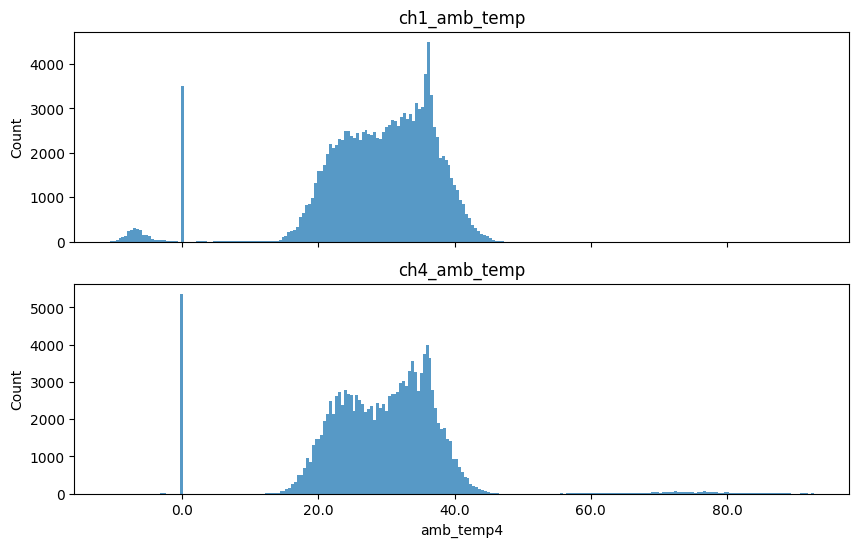

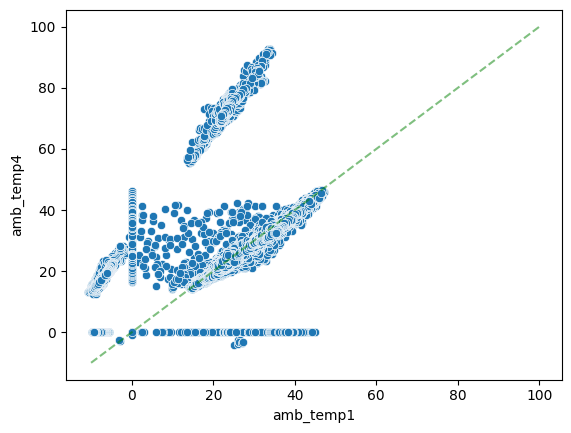

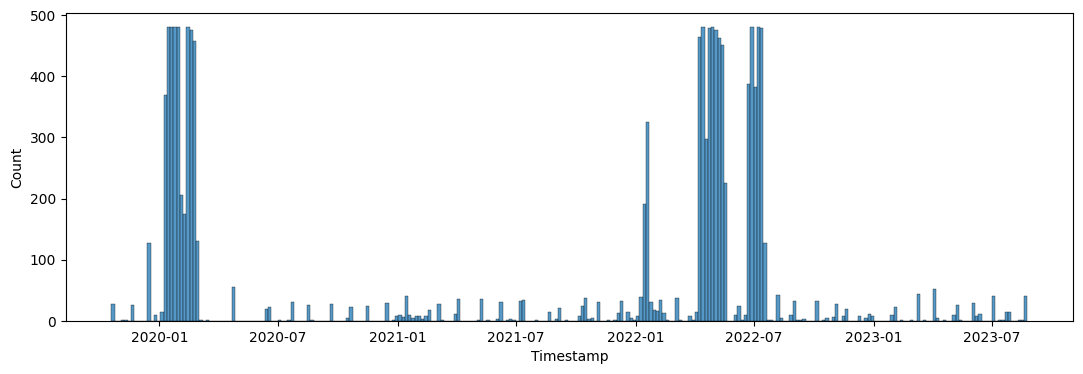

In [3]:
t=res.copy()
fig,(ax1,ax2)=plt.subplots(2,1,figsize=[10,6],sharex=True)
sns.histplot(t.amb_temp1,ax=ax1,linewidth=0)
sns.histplot(t.amb_temp4,ax=ax2,linewidth=0)
ax1.set_xticklabels(ax1.get_xticks(),rotation=45)
# ax1.set_xticks(np.arange(-20,100,10),rotation=45)
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_title('ch1_amb_temp')
ax2.set_title('ch4_amb_temp')
# ax1.set_yscale('log')
plt.figure()
ax1=sns.scatterplot(x=t.amb_temp1,y=t.amb_temp4)
sns.lineplot(x=[-10, 100], y=[-10, 100], linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax1)
plt.figure(figsize=[13,4])
ax=sns.histplot(t[abs(t.amb_temp1-t.amb_temp4)>5].index,binwidth=5)

In [4]:
timestamp=pd.Series(pd.date_range('2019-09-17 16:00:00','2023-08-31 23:00:00',freq='1h'),name='ts')
tweb=pd.read_csv('..\\00 2022\\03-27 import weather data\Dubai 19-23Aug.csv')
tweb.columns
tweb['ts']=pd.to_datetime(tweb['valid_time_gmt'],format='%Y-%m-%d %H:%M:%S')
tweb=tweb.merge(timestamp,how='right')[['temp','ts']].set_index('ts')
print('temperature from web')
tweb
# timestamp
# tweb[['timestamp','temp']].groupby(pd.Grouper(key='timestamp',freq='1h')).mean()

temperature from web


,temp
ts,
2019-09-17 16:00:00,38.0
2019-09-17 17:00:00,36.0
2019-09-17 18:00:00,36.0
2019-09-17 19:00:00,35.0
2019-09-17 20:00:00,35.0
...,...
2023-08-31 19:00:00,36.0
2023-08-31 20:00:00,37.0
2023-08-31 21:00:00,37.0


In [12]:
tbase=pd.read_csv('..\\02-10 RTU ML Model\Dubai_TRH_2022_15mins.csv',index_col=0)

tbase['MDate_']=pd.to_datetime(tbase.index).strftime('%m-%d %H:%M:%S')
tbase
t['MDate_']=pd.to_datetime(t.index).strftime('%m-%d %H:%M:%S')
t['Timestamp']=pd.to_datetime(t.index).strftime('%Y-%m-%d %H:%M:%S')
t1=t.merge(tbase)
t1=t1.set_index(pd.to_datetime(t1.Timestamp,format='%Y-%m-%d %H:%M:%S'))

t1=t1[['amb_temp1','amb_temp4','Temp']].groupby(pd.Grouper(freq='1h')).mean()
t1['ts']=t1.index
# t1.merge(timestamp,how='right')


In [46]:
t2=t1.iloc[1:].drop('ts',axis=1) # remove first reading
t2['Temp_w']=tweb['temp']
t2
id=t2[t2.Temp_w.isna()].index

In [47]:
t2


,amb_temp1,amb_temp4,Temp,Temp_w
Timestamp,,,,
2019-09-17 16:00:00,36.3050,36.0150,35.5590,38.0
2019-09-17 17:00:00,36.0000,35.3750,34.8295,36.0
2019-09-17 18:00:00,35.8600,35.1100,34.3475,36.0
2019-09-17 19:00:00,34.8775,34.1400,34.1180,35.0
2019-09-17 20:00:00,34.4575,33.7475,34.0335,35.0
...,...,...,...,...
2023-08-31 19:00:00,37.0775,35.0425,33.8800,36.0
2023-08-31 20:00:00,36.3500,34.3600,33.7145,37.0
2023-08-31 21:00:00,35.8025,33.8625,33.5920,37.0


In [55]:
t2.loc[id]

,amb_temp1,amb_temp4,Temp,Temp_w
Timestamp,,,,
2019-11-07 02:00:00,27.7375,28.2075,25.6395,NaN
2019-11-20 11:00:00,22.0275,22.4750,30.0990,NaN
2019-11-20 12:00:00,21.4725,21.9850,30.5480,NaN
2020-01-03 05:00:00,20.2775,19.7500,23.3680,NaN
2020-09-25 12:00:00,40.7075,39.3925,37.6325,NaN
...,...,...,...,...
2022-07-11 04:00:00,0.0000,33.5875,33.8320,NaN
2023-02-20 20:00:00,20.5250,20.0575,24.1060,NaN
2023-03-19 15:00:00,25.4325,24.9175,24.3925,NaN


In [70]:
# t2.loc[r[r>2].index]
def fix(x):
    r=[0.7,0.3]
    diff14=abs(x.amb_temp1-x.amb_temp4)
    diff1b=abs(x.amb_temp1-x.Temp)
    diff4b=abs(x.amb_temp4-x.Temp)
    if diff14<2:
        return x[['amb_temp1','amb_temp4']].mean()
    elif diff1b<diff4b :
        # if diff1b>2:
        #     print(x.name)
        print(diff1b)
            
        return x.amb_temp1*r[0]+x.Temp*r[1]
    else:
        print(diff4b)
        return x.amb_temp4*r[0]+x.Temp*r[1]
# more efficient way of applying the function
# instead of iterating over ALL values, we run over faulty values
r=t2.copy()
r.loc[r.Temp_w.isna(),'Temp_w']=r.loc[r.Temp_w.isna()].apply(lambda x: fix(x),axis=1)
# t2.loc[id]


0.7469999999999999
1.0544999999999973
0.28250000000000597
1.1140000000000008
0.670499999999997
1.108000000000004
1.9180000000000028
0.4480000000000004
0.9329999999999998
0.046999999999997044
1.4135000000000026
1.0375000000000014
6.006499999999999
0.32500000000000284
0.7220000000000013
0.6210000000000022
0.900500000000001
0.47599999999999554
0.1665000000000063
1.1340000000000003
1.2494999999999976
0.059499999999999886
0.9619999999999997
0.5340000000000025
0.7044999999999995
0.7360000000000007
0.24449999999998795


In [71]:
t2.loc['2022-01-15 08:00:00':'2022-01-15 12:00:00']
# t2.loc['2022-01-15 09:00:00']

,amb_temp1,amb_temp4,Temp,Temp_w
Timestamp,,,,
2022-01-15 08:00:00,20.5625,0.0,21.7555,21.0
2022-01-15 09:00:00,16.5225,0.0,22.5290,NaN
2022-01-15 10:00:00,22.7250,0.0,23.0500,NaN
2022-01-15 11:00:00,23.3750,0.0,23.9510,24.0
2022-01-15 12:00:00,26.6475,0.0,25.1625,24.0


In [17]:
n=3
t2[(abs(t2.Temp_w-t2.Temp)>n)&
   (abs(t2.Temp_w-t2.amb_temp4)>n)&
   (abs(t2.Temp_w-t2.amb_temp1)>n)
   ]

,amb_temp1,amb_temp4,Temp,Temp_w
Timestamp,,,,
2019-10-12 13:00:00,36.1950,35.4450,34.6480,40.000000
2019-12-17 16:00:00,22.9725,7.7650,26.4830,30.000000
2019-12-22 04:00:00,20.2750,21.9150,20.8580,17.000000
2019-12-22 09:00:00,24.1375,24.5275,24.3975,21.000000
2020-01-12 13:00:00,-7.5025,19.4250,24.1910,16.333333
...,...,...,...,...
2023-06-27 16:00:00,39.2600,38.4850,38.7300,42.500000
2023-07-08 11:00:00,40.9300,40.0550,36.1340,44.500000
2023-07-08 22:00:00,36.4950,36.1375,34.2330,41.000000


In [18]:
amb_temp=pd.Series(np.round(t2.Temp_w,2),name='amb_temp')
amb_temp.to_csv('amb_temp_hr.csv')